Reference: https://www.kaggle.com/code/ravaghi/drw-crypto-market-prediction-ensemble

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [3]:
train_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
test_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')


In [4]:

test_df = test_df.reset_index()
ids = test_df['ID'].copy()
test_df.drop(columns = ['ID'],inplace = True)

From data above, The training set ends on 2024-02-29, which gives us the forecast origin. The trainging set comprises the dates 2023-03-01 to 2024-02-29 (1 minute interval), and this gives us the forecast horizon. With unknown leadtime according to the unknown timestep from the test_df

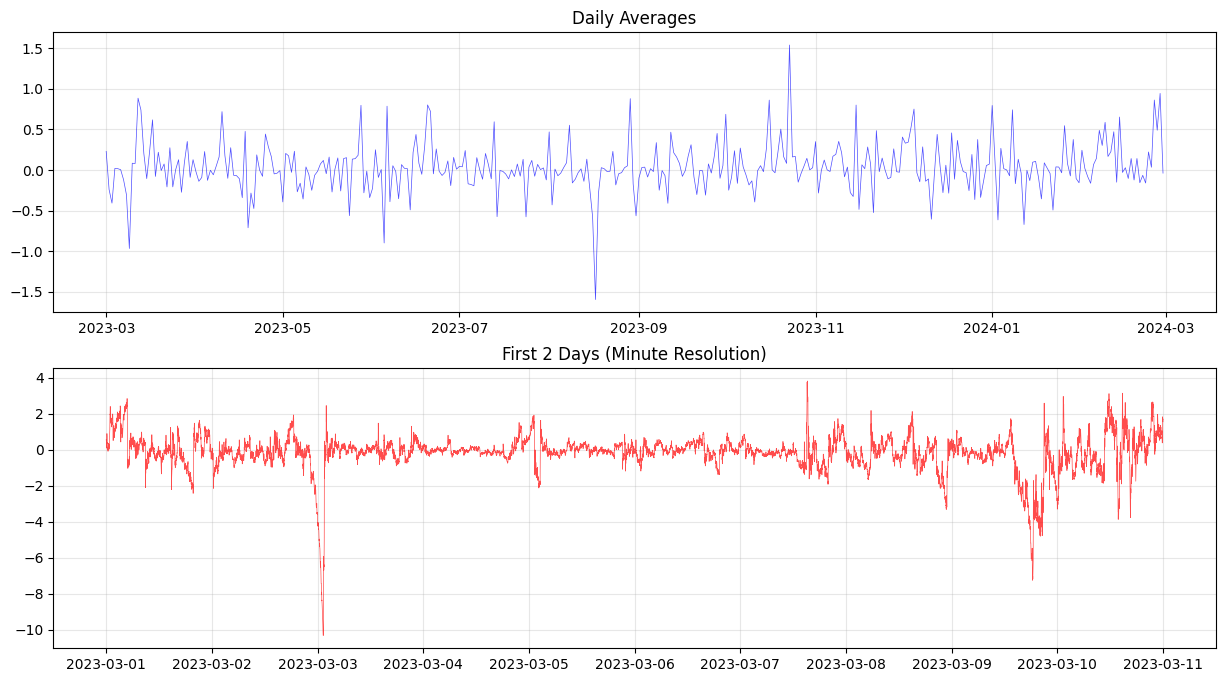

In [5]:
# Visualize data
daily = train_df['label'].resample('D').mean()  # Daily means
two_days = train_df['label'].head(1440*10)        # First 2 days (minute data)

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=False)

# Top plot (Daily)
ax1.plot(daily, 'b-', linewidth=0.5, alpha=0.7, label='Daily Mean')
ax1.set_title('Daily Averages')
ax1.grid(True, alpha=0.3)

# Bottom plot (2-day minute data)
ax2.plot(two_days, 'r-', linewidth=0.5, alpha=0.7, label='Minute Data')
ax2.set_title('First 2 Days (Minute Resolution)')
ax2.grid(True, alpha=0.3)




In general, there is not much mean trend through the entire year. Thus, Linear regression won't be used here. Instead, i will check seasonalities next

<Axes: title={'center': '1-Year Minute-Level Periodogram\n(525,600 data points)'}, xlabel='Frequency (cycles/year)', ylabel='Power (dB)'>

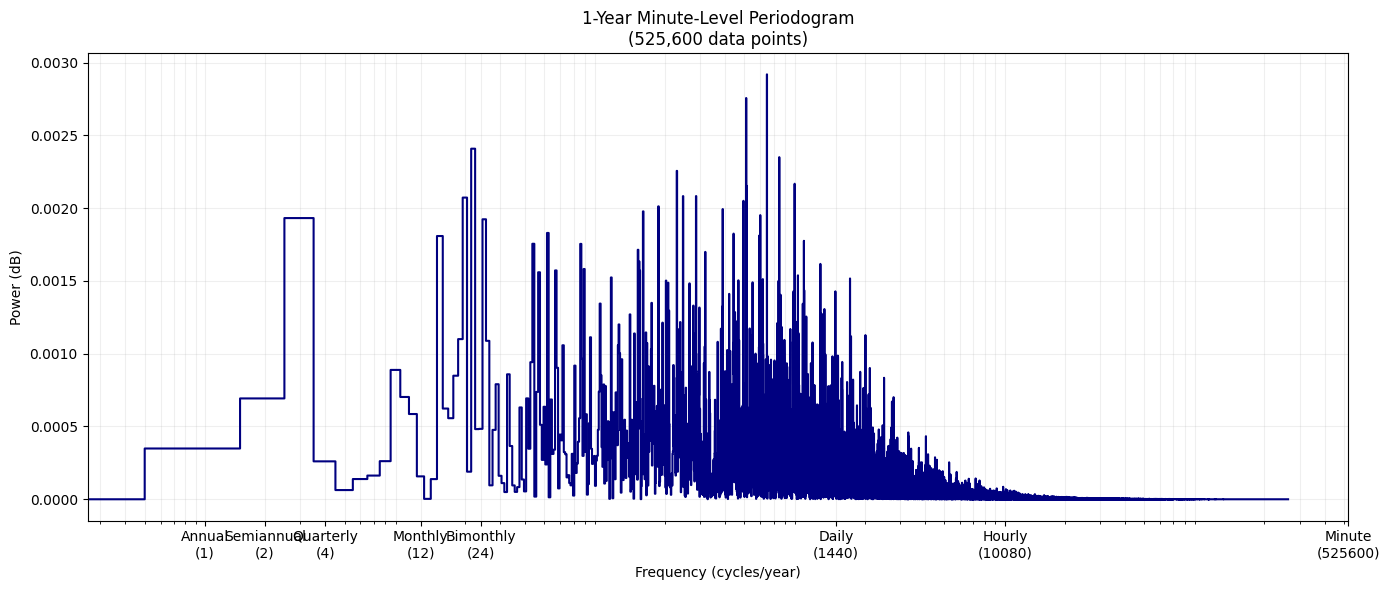

In [6]:
def plot_yearly_periodogram(ts, detrend='linear', ax=None):
    """
    Process exactly 1 year of minute-level data for periodogram analysis
    (Input must have DateTimeIndex with minute frequency)
    """
    from scipy.signal import periodogram
    
    # 1. Extract exactly 525,600 minutes (1 year)
    one_year = ts.iloc[:525600]  # Strictly first 525,600 entries
    
    # 2. Verify data completeness
    if len(one_year) < 525600:
        raise ValueError(f"Need 525,600 minutes (1 year). Got only {len(one_year)} points")
    
    # 3. Compute periodogram with correct sampling
    fs = 525600  # samples/year for minute data
    freqs, power = periodogram(
        one_year.dropna(),
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum'
    )
    
    # 4. Create plot
    if ax is None:
        _, ax = plt.subplots(figsize=(14, 6))
    
    ax.step(freqs, power, color='navy', where='mid')
    ax.set_xscale('log')
    
    # 5. Key frequency markers (cycles/year)
    periods = {
        1: 'Annual',
        2: 'Semiannual',
        4: 'Quarterly',
        12: 'Monthly',
        24: 'Bimonthly',
        1440: 'Daily',
        10080: 'Hourly',
        525600: 'Minute'
    }
    
    ax.set_xticks(list(periods.keys()))
    ax.set_xticklabels([f"{v}\n({k})" for k,v in periods.items()])
    
    # 6. Formatting
    ax.set_xlabel('Frequency (cycles/year)')
    ax.set_ylabel('Power (dB)')
    ax.set_title('1-Year Minute-Level Periodogram\n(525,600 data points)')
    ax.grid(True, which='both', alpha=0.2)
    plt.tight_layout()
    
    return ax

# Usage example:
plot_yearly_periodogram(train_df['label'])

# Exploring Lags

In [7]:
#from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.tsa.stattools import pacf

#plot_pacf(y,lags=range(2,15))
#plot_lags(y, lags=10, nrows=2);
# lags 1 3 4
#pacf_values = pacf(y, nlags=60)
#print(pacf_values)

#1,3,4,5,7,13 has relative high values

lags = [1,3,4,5,7,10,13,20,60,120,180,240,60*24,60*24*2,60*24*3,60*24*4,60*24*5]

# PCA Analysis

In [8]:
# Separate known features from anonymized features
known_features = ['timestamp', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
anonymized_features = [col for col in train_df.columns if col.startswith('X')]
target = 'label'

print(f"\nKnown features: {len(known_features)}")
print(f"Anonymized features: {len(anonymized_features)}")



Known features: 6
Anonymized features: 780


# Feature Analysis

In [9]:
print("\n" + "="*50)
print(" FEATURE RELATIONSHIPS ANALYSIS")
print("="*50)


correlation_matrix = train_df[anonymized_features  + [target]].corr()

def find_high_correlations(corr_matrix, threshold=0.95):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    return pd.DataFrame(high_corr_pairs)

high_corr_df = find_high_correlations(correlation_matrix, threshold=0.98)
print(f"High correlation pairs (|corr| > 0.98):")
print(high_corr_df.sort_values('correlation', key=abs, ascending=False).head(50))


 FEATURE RELATIONSHIPS ANALYSIS
High correlation pairs (|corr| > 0.98):
    feature1 feature2  correlation
107     X375     X417     1.000000
50      X128     X170     1.000000
36       X74     X116     1.000000
37       X74     X158     1.000000
38       X80     X122     1.000000
39       X80     X164     1.000000
40       X86     X128     1.000000
41       X86     X170     1.000000
42       X92     X134     1.000000
43       X92     X176     1.000000
44       X98     X140     1.000000
45       X98     X182     1.000000
46      X104     X146     1.000000
47      X110     X152     1.000000
97      X333     X375     1.000000
49      X122     X164     1.000000
51      X134     X176     1.000000
34       X68     X110     1.000000
52      X140     X182     1.000000
108     X381     X423     1.000000
101     X345     X387     1.000000
100     X339     X423     1.000000
99      X339     X381     1.000000
98      X333     X417     1.000000
109     X387     X429     1.000000
89      X309     

In [10]:
high_corr_df['feature2'].drop_duplicates().to_csv("features_drop.csv", index=False)
drop_col = high_corr_df['feature2'].drop_duplicates()

In [11]:
train_df = train_df.drop(columns=drop_col)
test_df = test_df.drop(columns=drop_col)


3. DIMENSIONALITY REDUCTION
Performing Incremental PCA...
Number of components needed for 90% variance: 95
Number of components needed for 95% variance: 144


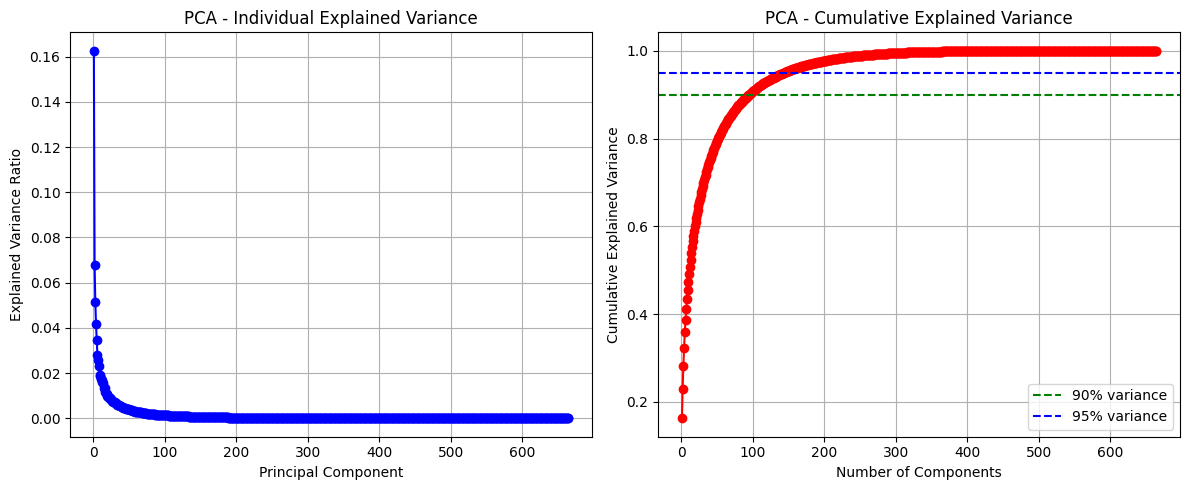

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("3. DIMENSIONALITY REDUCTION")
print("="*50)
anonymized_features = [col for col in train_df.columns if col.startswith('X')]

# 1.Downcast to float32 to save memory
X_features = train_df[anonymized_features]
X_features = X_features.astype(np.float32)

# 2. Standardize features
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

# 3. Perform Incremental PCA
print("Performing Incremental PCA...")
ipca = IncrementalPCA(n_components=664 , batch_size=664 *5)
X_pca = ipca.fit_transform(X_features)

# 4. Explained variance analysis
explained_variance_ratio = ipca.explained_variance_ratio_
cumsum_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"Number of components needed for 90% variance: {n_components_90}")
print(f"Number of components needed for 95% variance: {n_components_95}")

# 5. Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Individual Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumsum_variance) + 1),
         cumsum_variance, 'ro-')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Results:
# ==================================================
# 3. DIMENSIONALITY REDUCTION
# ==================================================
# Performing Incremental PCA...
# Number of components needed for 90% variance: 95
# Number of components needed for 95% variance: 144

# Feature selection

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd

print("\n" + "="*50)
print("4. FEATURE SELECTION")
print("="*50)
y = train_df['label']
# Univariate feature selection
print("Performing univariate feature selection...")
selector_univariate = SelectKBest(score_func=f_regression, k=100)
X_selected_univariate = selector_univariate.fit_transform(X_features, y)

# Get feature scores
#anonymized_features = X_clean.columns  # <-- Make sure this matches the full feature list
feature_scores = pd.DataFrame({
    'feature': anonymized_features,
    'score': selector_univariate.scores_
}).sort_values('score', ascending=False)

print("Top 20 features by univariate selection:")
print(feature_scores.head(20))


4. FEATURE SELECTION
Performing univariate feature selection...
Top 20 features by univariate selection:
    feature        score
638    X752  4348.622991
16      X21  2545.200402
15      X20  2419.038149
23      X28  2169.159307
645    X759  2166.779317
24      X29  2051.626665
14      X19  2048.609665
22      X27  2045.848307
17      X22  1755.190009
640    X754  1733.551505
182    X219  1699.526771
642    X756  1669.739534
236    X287  1648.014441
238    X293  1612.616202
639    X753  1577.406436
508    X614  1568.260815
181    X218  1523.110959
637    X751  1511.331377
239    X298  1487.198378
21      X26  1409.232975


In [15]:
# ==================================================
# 4. FEATURE SELECTION
# ==================================================
# Performing univariate feature selection...
# Top 20 features by univariate selection:
#     feature        score
# 638    X752  4348.622991
# 16      X21  2545.200402
# 15      X20  2419.038149
# 23      X28  2169.159307
# 645    X759  2166.779317
# 24      X29  2051.626665
# 14      X19  2048.609665
# 22      X27  2045.848307
# 17      X22  1755.190009
# 640    X754  1733.551505
# 182    X219  1699.526771
# 642    X756  1669.739534
# 236    X287  1648.014441
# 238    X293  1612.616202
# 639    X753  1577.406436
# 508    X614  1568.260815
# 181    X218  1523.110959
# 637    X751  1511.331377
# 239    X298  1487.198378
# 21      X26  1409.232975

In [16]:
feature_scores['feature'].to_csv("fs_features.csv", index=False)

# Random Forest feature importance

In [17]:
from sklearn.ensemble import RandomForestRegressor

print("\nTraining Random Forest for feature importance (with speed-up)...")

rf = RandomForestRegressor(
    n_estimators=100,       # Reduce trees from 100 → 50 for faster training
    max_depth=10,          # Limit depth to prevent very deep trees
    max_features='sqrt',   # Use sqrt of features at each split (default)
    n_jobs=-1,             # Use all CPU cores
    random_state=42
)

rf.fit(X_features, y)

feature_importance = pd.DataFrame({
    'feature': anonymized_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 features by Random Forest importance:")
print(feature_importance.head(20))


Training Random Forest for feature importance (with speed-up)...
Top 20 features by Random Forest importance:
    feature  importance
384    X465    0.016714
385    X466    0.016393
644    X758    0.009968
68      X89    0.009624
232    X279    0.008647
74      X95    0.008646
576    X682    0.008387
161    X198    0.008243
145    X179    0.007663
383    X464    0.007436
364    X445    0.007083
236    X287    0.006683
638    X752    0.006629
507    X613    0.006403
349    X426    0.006333
181    X218    0.006309
484    X588    0.006289
663    X780    0.006269
75      X96    0.006252
180    X217    0.006245


In [18]:
# Top 20 features by Random Forest importance:
#     feature  importance
# 384    X465    0.016714
# 385    X466    0.016393
# 644    X758    0.009968
# 68      X89    0.009624
# 232    X279    0.008647
# 74      X95    0.008646
# 576    X682    0.008387
# 161    X198    0.008243
# 145    X179    0.007663
# 383    X464    0.007436
# 364    X445    0.007083
# 236    X287    0.006683
# 638    X752    0.006629
# 507    X613    0.006403
# 349    X426    0.006333
# 181    X218    0.006309
# 484    X588    0.006289
# 663    X780    0.006269
# 75      X96    0.006252
# 180    X217    0.006245

In [19]:
feature_importance['feature'].to_csv("rf_features.csv", index=False)


<!-- Performing univariate feature selection...
Top 20 features by univariate selection:
    feature        score
751    X752  4348.622991
20      X21  2545.200402
19      X20  2419.038149
27      X28  2169.159307
758    X759  2166.779317
28      X29  2051.626665
18      X19  2048.609665
26      X27  2045.848307
21      X22  1755.190009
753    X754  1733.551505
218    X219  1699.526771
755    X756  1669.739534
286    X287  1648.014441
288    X289  1647.961958
290    X291  1621.047475
292    X293  1612.616202
752    X753  1577.406436
294    X295  1574.585720
613    X614  1568.260815
217    X218  1523.110959 -->

# Recursive Feature Elimination

In [20]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

print("\nPerforming Recursive Feature Elimination with Lasso...")

# Initialize Lasso with a small alpha (regularization strength) and enough iterations
lasso = Lasso(alpha=0.01, max_iter=10000, random_state=42)

# RFE with step=50 (removes 50 features at a time) to speed up
rfe = RFE(estimator=lasso, n_features_to_select=100, step=50)

# Fit RFE on your data
rfe.fit(X_features, y)

# Collect feature selection results
rfe_features = pd.DataFrame({
    'feature': anonymized_features,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')

selected_features_rfe = rfe_features[rfe_features['selected']]['feature'].tolist()
print(f"RFE selected {len(selected_features_rfe)} features")
print("Top 20 RFE selected features:")
print(rfe_features.head(20))


Performing Recursive Feature Elimination with Lasso...
RFE selected 100 features
Top 20 RFE selected features:
    feature  selected  ranking
663    X780      True        1
364    X445      True        1
584    X692      True        1
380    X461      True        1
381    X462      True        1
384    X465      True        1
182    X219      True        1
565    X671      True        1
406    X487      True        1
407    X495      True        1
161    X198      True        1
412    X500      True        1
159    X196      True        1
542    X648      True        1
420    X508      True        1
151    X186      True        1
144    X178      True        1
142    X175      True        1
127    X157      True        1
122    X151      True        1


In [21]:
# Performing Recursive Feature Elimination with Lasso...
# RFE selected 100 features
# Top 20 RFE selected features:
#     feature  selected  ranking
# 231    X278      True        1
# 4        X5      True        1
# 182    X219      True        1
# 613    X727      True        1
# 600    X711      True        1
# 209    X253      True        1
# 161    X198      True        1
# 159    X196      True        1
# 151    X186      True        1
# 144    X178      True        1
# 142    X175      True        1
# 242    X306      True        1
# 236    X287      True        1
# 234    X281      True        1
# 5        X6      True        1
# 230    X277      True        1
# 224    X271      True        1
# 631    X745      True        1
# 630    X744      True        1
# 629    X743      True        1

In [22]:
rfe_features['feature'].to_csv("rfe_features.csv", index=False)

In [23]:
# Correlation with target variable
target_correlations = train_df[anonymized_features + [target]].corr()[target].abs().sort_values(ascending=False)
print(f"\nTop 20 features most correlated with target:")
print(target_correlations.head(51)[1:]) 


Top 20 features most correlated with target:
X752    0.090561
X21     0.069401
X20     0.067667
X28     0.064092
X759    0.064057
X29     0.062339
X19     0.062293
X27     0.062251
X22     0.057676
X754    0.057320
X219    0.056757
X756    0.056259
X287    0.055893
X293    0.055291
X753    0.054686
X614    0.054528
X218    0.053739
X751    0.053532
X298    0.053104
X26     0.051697
X292    0.051509
X30     0.049594
X465    0.049583
X18     0.049539
X466    0.049255
X181    0.049164
X286    0.048661
X281    0.047865
X217    0.046178
X175    0.045815
X757    0.045515
X226    0.045165
X225    0.045025
X23     0.044959
X508    0.044525
X137    0.044290
X95     0.042948
X198    0.042872
X272    0.042536
X472    0.042454
X277    0.042090
X224    0.041704
X656    0.041682
X652    0.041440
X31     0.040834
X758    0.040828
X131    0.040582
X89     0.040520
X278    0.040439
X464    0.040402
Name: label, dtype: float64


In [24]:
pd.DataFrame(target_correlations.index[1:], columns=["feature"]).to_csv("tc_features.csv", index=False)

In [25]:
print("\n" + "="*80)
print("SUMMARY INSIGHTS")
print("="*80)

print(f"1. Dataset contains {780} anonymized features")
print(f"2. {n_components_90} components explain 90% of variance, {n_components_95} explain 95%")
print(f"3. Top correlated feature with target: {target_correlations.index[1]} (corr: {target_correlations.iloc[1]:.4f})")
#print(f"4. {len(high_corr_df)} feature pairs have high correlation (>0.7)")

# Save important features for further analysis
important_features = {
    'top_univariate': feature_scores.head(100)['feature'].tolist(),
    'top_rf_importance': feature_importance.head(100)['feature'].tolist(),
    'rfe_selected': selected_features_rfe,
    'high_target_corr': target_correlations.head(100).index[1:].tolist()
}

common_features = set(important_features['top_univariate']) & \
                 set(important_features['top_rf_importance']) & \
                 set(important_features['rfe_selected'])& \
                set(important_features['high_target_corr'])
print(f"  Common Features selected by all 4 methods: {(common_features)}")


SUMMARY INSIGHTS
1. Dataset contains 780 anonymized features
2. 95 components explain 90% of variance, 144 explain 95%
3. Top correlated feature with target: X752 (corr: 0.0906)
  Common Features selected by all 4 methods: {'X22', 'X219', 'X445', 'X508', 'X752', 'X758', 'X385', 'X762', 'X278', 'X465', 'X751', 'X444', 'X175', 'X198', 'X614', 'X287', 'X759', 'X271', 'X281'}


In [26]:


# ================================================================================
# SUMMARY INSIGHTS
# ================================================================================
# 1. Dataset contains 890 anonymized features
# 2. 91 components explain 90% of variance, 140 explain 95%
# 3. Top correlated feature with target: X752 (corr: 0.0906)
#   Common Features selected by all 3 methods: {'X614', 'X219', 'X385', 'X445', 'X181', 'X465', 'X22', 'X508', 'X278', 'X198', 'X752', 'X751', 'X758', 'X283', 'X759'}